In [1]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import torch.utils.data as Data
import matplotlib as mpl
import scipy.io as sio
import numpy as np
import argparse
import h5py
import time

import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn
from sklearn.metrics import confusion_matrix


from data_prepare import mirror_hsi
from Utils import ActivationOutputData, safe_norm
from caps_vit import CapsViT, Margin_Recon_Loss
from data_prepare import choose_train_and_test_number
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from data_prepare import choose_train_and_test_proportion
from Utils import list_to_colormap, classification_map, print_args
from data_prepare import train_and_test_data, train_and_test_label


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='CAF', help='mode choice')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=9, help='size of patches')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
args = parser.parse_args(args=[])

In [4]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [6]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_proportion(label, args.train_proportion)
#  Don't forget to modify the choose_train_and_test_proportion function in the data_prepare module.

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=176


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

**************************************************
patch_size is : 9
mirror_data shape : [520, 622, 176]
**************************************************
x_train shape = (528, 9, 9, 176), type = float64
x_test  shape = (4683, 9, 9, 176), type = float64
x_true  shape = (5211, 9, 9, 176), type = float64
**************************************************


In [8]:
y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (13, 176, 7, 7)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 176, 7, 7)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 176, 7, 7)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=True)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

y_train: shape = (528,), type = int64
y_test: shape = (4683,), type = int64
y_true: shape = (5211,), type = int64
**************************************************
torch.Size([528, 176, 9, 9])
torch.Size([4683, 176, 9, 9])
torch.Size([5211, 176, 9, 9])


In [9]:
model = CapsViT(band, args.patch_size, preliminary_layer_channels=96, mode=args.mode, caps2_caps=num_classes)

model = model.cuda()
# criterion
criterion = Margin_Recon_Loss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches//10, gamma=args.gamma)

In [10]:
print('start training')
# train model
model.train()
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = train_epoch(model, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 train_loss: 0.5471 train_acc: 28.5985
Epoch: 002 train_loss: 0.3263 train_acc: 53.7879
Epoch: 003 train_loss: 0.2498 train_acc: 66.6667
Epoch: 004 train_loss: 0.2066 train_acc: 75.5682
Epoch: 005 train_loss: 0.1815 train_acc: 78.0303
Epoch: 006 train_loss: 0.1571 train_acc: 82.9546
Epoch: 007 train_loss: 0.1418 train_acc: 83.9015
Epoch: 008 train_loss: 0.1253 train_acc: 87.5000
Epoch: 009 train_loss: 0.1121 train_acc: 89.5833
Epoch: 010 train_loss: 0.1033 train_acc: 90.1515
Epoch: 011 train_loss: 0.0942 train_acc: 91.4773
Epoch: 012 train_loss: 0.0906 train_acc: 92.6136
Epoch: 013 train_loss: 0.0845 train_acc: 92.2348
Epoch: 014 train_loss: 0.0831 train_acc: 93.1818
Epoch: 015 train_loss: 0.0792 train_acc: 94.1288
Epoch: 016 train_loss: 0.0752 train_acc: 93.1818
Epoch: 017 train_loss: 0.0729 train_acc: 94.3182
Epoch: 018 train_loss: 0.0707 train_acc: 95.2652
Epoch: 019 train_loss: 0.0694 train_acc: 95.2652
Epoch: 020 train_loss: 0.0680 train_acc: 96.2121
Epoch

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


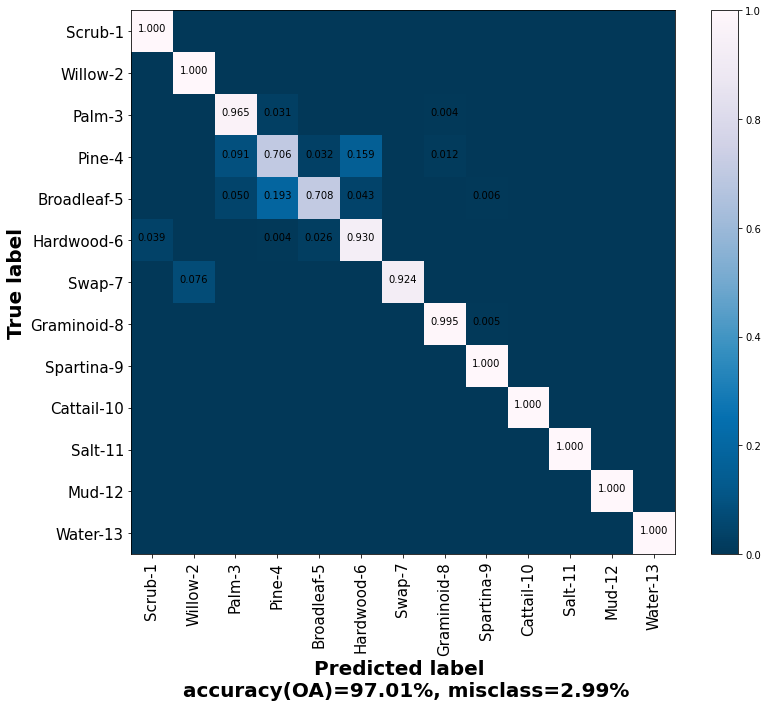

**************************************************
Final result:
OA: 96.71% | AA: 93.45% | Kappa: 0.9634
[1.         1.         0.96521739 0.67699115 0.67361111 0.9223301
 0.91489362 0.99483204 1.         1.         1.         1.
 1.        ]
**************************************************
Parameter:
dataset: KSC
flag_test: train
mode: CAF
gpu_id: 0
seed: 0
batch_size: 32
patch_size: 9
epoches: 200
learning_rate: 0.0005
gamma: 0.99
weight_decay: 0.001
train_number: 1
train_proportion: 0.1
**************************************************


In [11]:
model.eval()
tar_test, pre_test = test_epoch(model, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = valid_epoch(model, true_loader)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_CapsCAF.pdf')



print("**************************************************")
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))
print("**************************************************")

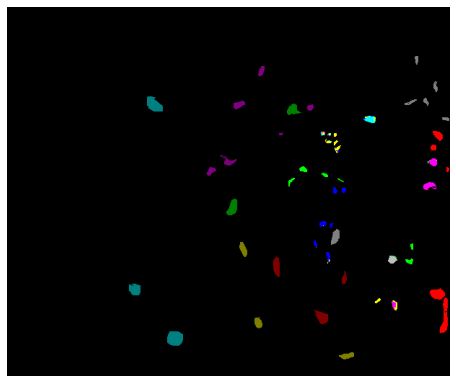

In [12]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

true_map = list_to_colormap(label.ravel())
true_map = np.reshape(true_map, (height, width, 3))
#classification_map(true_map, './GT.pdf')
classification_map(predict_map, './Predict_Map.pdf')